In [27]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from PIL import Image
import os
import os.path
import glob
import argparse


Start finding chessboard corners...
find the chessboard corners of depth_chessboard_data\01.png
find the chessboard corners of depth_chessboard_data\02.png
find the chessboard corners of depth_chessboard_data\03.png
find the chessboard corners of depth_chessboard_data\04.png
find the chessboard corners of depth_chessboard_data\05.png
find the chessboard corners of depth_chessboard_data\06.png
find the chessboard corners of depth_chessboard_data\07.png


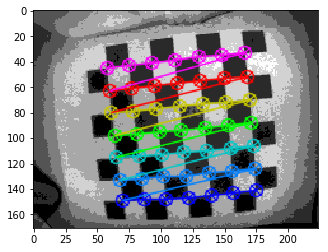

In [18]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# (8,6) is for the given testing images.
# If you use the another data (e.g. pictures you take by your smartphone), 
# you need to set the corresponding numbers.
corner_x = 7
corner_y = 7
objp = np.zeros((corner_x*corner_y,3), np.float32)
objp[:,:2] = np.mgrid[0:corner_x, 0:corner_y].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

img_size = (10, 10)

# Make a list of calibration images
images = glob.glob('depth_chessboard_data/*.png')

# Step through the list and search for chessboard corners
print('Start finding chessboard corners...')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)
    img_size = (img.shape[1], img.shape[0])

    #Find the chessboard corners
    print('find the chessboard corners of',fname)
    ret, corners = cv2.findChessboardCorners(gray, (corner_x,corner_y), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (corner_x,corner_y), corners, ret)
        plt.imshow(img)
        

In [21]:
print('Camera calibration...')
img_size = (img.shape[1], img.shape[0])
# You need to comment these functions and write your calibration function from scratch.
# Notice that rvecs is rotation vector, not the rotation matrix, and tvecs is translation vector.
# In practice, you'll derive extrinsics matrixes directly. The shape must be [pts_num,3,4], and use them to plot.
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
Vr = np.array(rvecs)
Tr = np.array(tvecs)
extrinsics = np.concatenate((Vr, Tr), axis=1).reshape(-1,6)
print(mtx)

Camera calibration...
[[210.95738167   0.         115.48354768]
 [  0.         210.93681818  80.18596308]
 [  0.           0.           1.        ]]


In [26]:
def main():
    parser = argparse.ArgumentParser(
        description='Calibrate pro-cam system using chessboard and structured light projection\n'
        '  Place captured images as \n'
        '    ./ --- capture_1/ --- graycode_00.png\n'
        '        |              |- graycode_01.png\n'
        '        |              |        .\n'
        '        |              |        .\n'
        '        |              |- graycode_??.png\n'
        '        |- capture_2/ --- graycode_00.png\n'
        '        |              |- graycode_01.png\n'
        '        |      .       |        .\n'
        '        |      .       |        .\n',
        formatter_class=argparse.RawTextHelpFormatter
    )

    parser.add_argument('proj_height', type=int, help='projector pixel height')
    parser.add_argument('proj_width', type=int, help='projector pixel width')
    parser.add_argument('chess_vert', type=int,
                        help='number of cross points of chessboard in vertical direction')
    parser.add_argument('chess_hori', type=int,
                        help='number of cross points of chessboard in horizontal direction')
    parser.add_argument('chess_block_size', type=float,
                        help='size of blocks of chessboard (mm or cm or m)')
    parser.add_argument('graycode_step', type=int,
                        default=1, help='step size of graycode')
    parser.add_argument('-black_thr', type=int, default=40,
                        help='threashold to determine whether a camera pixel captures projected area or not (default : 40)')
    parser.add_argument('-white_thr', type=int, default=5,
                        help='threashold to specify robustness of graycode decoding (default : 5)')

    args = parser.parse_args()

    proj_shape = (args.proj_height, args.proj_width)
    chess_shape = (args.chess_vert, args.chess_hori)
    chess_block_size = args.chess_block_size
    gc_step = args.graycode_step
    black_thr = args.black_thr
    white_thr = args.white_thr

    dirnames = sorted(glob.glob('./capture_*'))
    if len(dirnames) == 0:
        print('Directories \'./capture_*\' were not found')
        return

    print('Searching input files ...')
    used_dirnames = []
    gc_fname_lists = []
    for dname in dirnames:
        gc_fnames = sorted(glob.glob(dname + '/graycode_*'))
        if len(gc_fnames) == 0:
            continue
        used_dirnames.append(dname)
        gc_fname_lists.append(gc_fnames)
        print(' \'' + dname + '\' was found')

    proj_objps_list, proj_corners_list = calibrate(used_dirnames, gc_fname_lists,
              proj_shape, chess_shape, chess_block_size, gc_step, black_thr, white_thr)
    
    print('Initial solution of projector\'s parameters')
    ret, proj_int, proj_dist, proj_rvecs, proj_tvecs = cv2.calibrateCamera(
        proj_objps_list, proj_corners_list, proj_shape, None, None, None, None)
    print('  RMS :', ret)
    print('  Intrinsic parameters :')
    printNumpyWithIndent(proj_int, '    ')
    print('  Distortion parameters :')
    printNumpyWithIndent(proj_dist, '    ')
    print()

    print('=== Result ===')
    ret, cam_int, cam_dist, proj_int, proj_dist, cam_proj_rmat, cam_proj_tvec, E, F = cv2.stereoCalibrate(
        proj_objps_list, imgpoints, proj_corners_list, mtx, dist, proj_int, proj_dist, None)
    print('  RMS :', ret)
    print('  Camera intrinsic parameters :')
    printNumpyWithIndent(cam_int, '    ')
    print('  Camera distortion parameters :')
    printNumpyWithIndent(cam_dist, '    ')
    print('  Projector intrinsic parameters :')
    printNumpyWithIndent(proj_int, '    ')
    print('  Projector distortion parameters :')
    printNumpyWithIndent(proj_dist, '    ')
    print('  Rotation matrix / translation vector from camera to projector')
    print('  (they translate points from camera coord to projector coord) :')
    printNumpyWithIndent(cam_proj_rmat, '    ')
    printNumpyWithIndent(cam_proj_tvec, '    ')
    print()

In [23]:
def calibrate(dirnames, gc_fname_lists, proj_shape, chess_shape, chess_block_size, gc_step, black_thr, white_thr):
    objps = np.zeros((chess_shape[0]*chess_shape[1], 3), np.float32)
    objps[:, :2] = chess_block_size * \
        np.mgrid[0:chess_shape[0], 0:chess_shape[1]].T.reshape(-1, 2)

    print('Calibrating ...')
    gc_height = int((proj_shape[0]-1)/gc_step)+1
    gc_width = int((proj_shape[1]-1)/gc_step)+1
    graycode = cv2.structured_light_GrayCodePattern.create(
        gc_width, gc_height)
    graycode.setBlackThreshold(black_thr)
    graycode.setWhiteThreshold(white_thr)

    cam_shape = cv2.imread(gc_fname_lists[0][0], cv2.IMREAD_GRAYSCALE).shape
    patch_size_half = int(np.ceil(cam_shape[1] / 180))
    print('  patch size :', patch_size_half * 2 + 1)

    cam_corners_list = []
    cam_objps_list = []
    cam_corners_list2 = []
    proj_objps_list = []
    proj_corners_list = []
    for dname, gc_filenames in zip(dirnames, gc_fname_lists):
        print('  checking \'' + dname + '\'')
        if len(gc_filenames) != graycode.getNumberOfPatternImages() + 2:
            print('Error : invalid number of images in \'' + dname + '\'')
            return None

        imgs = []
        for fname in gc_filenames:
            img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
            if cam_shape != img.shape:
                print('Error : image size of \'' + fname + '\' is mismatch')
                return None
            imgs.append(img)
        black_img = imgs.pop()
        white_img = imgs.pop()

        res, cam_corners = cv2.findChessboardCorners(white_img, chess_shape)
        if not res:
            print('Error : chessboard was not found in \'' +
                  gc_filenames[-2] + '\'')
            return None
        cam_objps_list.append(objps)
        cam_corners_list.append(cam_corners)

        proj_objps = []
        proj_corners = []
        cam_corners2 = []
        # viz_proj_points = np.zeros(proj_shape, np.uint8)
        for corner, objp in zip(cam_corners, objps):
            c_x = int(round(corner[0][0]))
            c_y = int(round(corner[0][1]))
            src_points = []
            dst_points = []
            for dx in range(-patch_size_half, patch_size_half + 1):
                for dy in range(-patch_size_half, patch_size_half + 1):
                    x = c_x + dx
                    y = c_y + dy
                    if int(white_img[y, x]) - int(black_img[y, x]) <= black_thr:
                        continue
                    err, proj_pix = graycode.getProjPixel(imgs, x, y)
                    if not err:
                        src_points.append((x, y))
                        dst_points.append(gc_step*np.array(proj_pix))
            if len(src_points) < patch_size_half**2:
                print(
                    '    Warning : corner', c_x, c_y,
                    'was skiped because decoded pixels were too few (check your images and threasholds)')
                continue
            h_mat, inliers = cv2.findHomography(
                np.array(src_points), np.array(dst_points))
            point = h_mat@np.array([corner[0][0], corner[0][1], 1]).transpose()
            point_pix = point[0:2]/point[2]
            proj_objps.append(objp)
            proj_corners.append([point_pix])
            cam_corners2.append(corner)
            # viz_proj_points[int(round(point_pix[1])),
            #                 int(round(point_pix[0]))] = 255
        if len(proj_corners) < 3:
            print('Error : too few corners were found in \'' +
                  dname + '\' (less than 3)')
            return None
        proj_objps_list.append(np.float32(proj_objps))
        proj_corners_list.append(np.float32(proj_corners))
        cam_corners_list2.append(np.float32(cam_corners2))
        
    return proj_objps_list, proj_corners_list

In [24]:
def printNumpyWithIndent(tar, indentchar):
    print(indentchar + str(tar).replace('\n', '\n' + indentchar))